<a href="https://colab.research.google.com/github/Srivishnu27feb/MNIST_TF_BN/blob/master/MNIST_TF_BN_Dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow==1.2
#!pip install -q git+https://github.com/tensorflow/examples.git
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

     |████████████████████████████████| 35.0MB 116kB/s 
     |████████████████████████████████| 890kB 37.3MB/s 
     |████████████████████████████████| 245kB 43.9MB/s 
  Created wheel for html5lib: filename=html5lib-0.9999999-cp36-none-any.whl size=107220 sha256=f6c1dc03662aef1df22f22d23cf0da103502426e6dfff2549a27dc9226299190
  Stored in directory: /root/.cache/pip/wheels/50/ae/f9/d2b189788efcf61d1ee0e36045476735c838898eef1cad6e29
  Created wheel for markdown: filename=Markdown-2.2.0-cp36-none-any.whl size=136283 sha256=b69ed635fdbab9fb6a67a418d5f1bbae0e4409a39a813d4c1e434686745de3bc
  Stored in directory: /root/.cache/pip/wheels/b6/52/17/f0af18e3e0ec6fa60b361ffed15b4c3468f6f3bcdb87fbe079
Successfully built html5lib markdown
ERROR: tensorboard 2.3.0 has requirement markdown>=2.6.8, but you'll have markdown 2.2.0 which is incompatible.
  Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Found existing installatio

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:461: FutureWarning: Passing (type, 1) or 

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
# %matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import time
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
def plt_dynamic(x, y, y_1, ax, ticks,title, colors=['b']):
    ax.plot(x, y, 'b', label="Train Loss")
    ax.plot(x, y_1, 'r', label="Test Loss")
    if len(x)==1:
        plt.legend()
        plt.title(title)
    plt.yticks(ticks)
    fig.canvas.draw()

In [3]:
# initialize params
# network params
n_input = 784
n_output = 10
n_hidden_1 = 512
n_hidden_2 = 128

In [4]:
# placeholder for input and output layer
x=tf.placeholder(tf.float32,[None,784])
y_=tf.placeholder(tf.float32,[None,10])
keep_prob = tf.placeholder(tf.float32) # dropout placeholder for testing
keep_prob_input = tf.placeholder(tf.float32) # dropout placeholder for training

In [5]:
# weight initialisation for sigmoid
# If we sample weights from a normal distribution N(0,σ) we satisfy this condition with σ=√(2/(ni+ni+1). 
# h1 =>  σ=√(2/(fan_in+fan_out+1) = 0.039  => N(0,σ) = N(0,0.039)
# h2 =>  σ=√(2/(fan_in+fan_out+1) = 0.055  => N(0,σ) = N(0,0.055)
# out =>  σ=√(2/(fan_in+fan_out+1) = 0.120  => N(0,σ) = N(0,0.120)
# SGD: Xavier/Glorot Normal initialization.

weights_sgd = {
    'h1' : tf.Variable(tf.random_normal([n_input,n_hidden_1],stddev=0.039,mean=0)), #784x512 # sqrt(2/(784+512)) = 0.039
    'h2' : tf.Variable(tf.random_normal([n_hidden_1,n_hidden_2],stddev=0.055,mean=0)), #512x128 # sqrt(2/(512+128)) = 0.055
    'out' : tf.Variable(tf.random_normal([n_hidden_2,n_output],stddev=0.120,mean=0)) # 128 * 10
}


In [6]:
#weight init for ReLU
# If we sample weights from a normal distribution N(0,σ) we satisfy this condition with σ=√(2/(ni). 
# h1 =>  σ=√(2/(fan_in+1) = 0.062  => N(0,σ) = N(0,0.062)
# h2 =>  σ=√(2/(fan_in+1) = 0.125  => N(0,σ) = N(0,0.125)
# out =>  σ=√(2/(fan_in+1) = 0.120  => N(0,σ) = N(0,0.120)
# He Normal initialization.

weights_relu = {
    'h1' : tf.Variable(tf.random_normal([n_input,n_hidden_1],stddev=0.062,mean=0)), #784x512 
    'h2' : tf.Variable(tf.random_normal([n_hidden_1,n_hidden_2],stddev=0.125,mean=0)), #512x128 
    'out' : tf.Variable(tf.random_normal([n_hidden_2,n_output],stddev=0.120,mean=0)) # 128 * 10
}


In [7]:
# weights init for biases

biases ={
    'b1' : tf.Variable(tf.random_normal([n_hidden_1])),
    'b2' : tf.Variable(tf.random_normal([n_hidden_2])),
    'out' : tf.Variable(tf.random_normal([n_output]))
}

In [8]:
# Parameters
training_epochs = 15
learning_rate = 0.001
batch_size = 100
display_step = 1

Model 1: input (784) - Dropout(RELU(BN(512))) - Droupout(RELU(BN(128))) - softmax(output 10)

In [9]:
epsilon = 1e-3
def MLP_RELU(x,weights,baises):
  print('x :',x.get_shape() , 'W[h1]:' , weights['h1'].get_shape() , 'W[h2]:', weights['h2'].get_shape() , 'B[h1]:', baises['b1'].get_shape())

  #hidden layer 1 
  layer_1 = tf.add(tf.matmul(x,weights['h1']),baises['b1'])
  # batch norm for layer 1
  # scale and shift thru moment
  batch_mean_1, batch_var_1  = tf.nn.moments(layer_1,[0])
  scale_1 = tf.Variable(tf.ones([n_hidden_1]))
  beta_1 = tf.Variable(tf.zeros([n_hidden_1]))

  # applying batch normalisation to layer 1
  layer_1 = tf.nn.batch_normalization(layer_1,batch_mean_1,batch_var_1,beta_1,scale_1,epsilon)


  # applying RELU activation layer to layer_1
  layer_1 = tf.nn.relu(layer_1)

  #adding dropout layer 
  #layer_1_drop = tf.nn.dropout(layer_1,keep_prob)


  # hidden layer 2 
  layer_2 = tf.add(tf.matmul(layer_1,weights['h2']),baises['b2'])
  # batch norm for layer 2
  # scale and shift thru moment
  batch_mean_2,batch_var_2 = tf.nn.moments(layer_2,[0])
  scale_2 = tf.Variable(tf.ones([n_hidden_2]))
  beta_2 = tf.Variable(tf.zeros([n_hidden_2]))
  
  # Applying batch normalization to layer 2
  layer_2 = tf.nn.batch_normalization(layer_2,batch_mean_2,batch_var_2,beta_2,scale_2,epsilon)

 # applying RELU activation layer to layer_2

  layer_2 = tf.nn.relu(layer_2)

  # adding dropout layer
  #layer_2_drop = tf.nn.dropout(layer_2,keep_prob)


  # output layer
  output_layer = tf.matmul(layer_2,weights['out']) + baises['out']
  # passing to sigmoid 
  output_layer = tf.nn.sigmoid(output_layer)

  return output_layer

__ Model MLP_RELU + AdamOptimizer __

x : (?, 784) W[h1]: (784, 512) W[h2]: (512, 128) B[h1]: (512,)
Epoch: 0001 train cost=1.568584989 test cost=1.559810386
Epoch: 0002 train cost=1.491513426 test cost=1.491073890
Epoch: 0003 train cost=1.481317712 test cost=1.484726188
Epoch: 0004 train cost=1.475966292 test cost=1.482288842
Epoch: 0005 train cost=1.473757090 test cost=1.481542939
Epoch: 0006 train cost=1.471075133 test cost=1.480826864
Epoch: 0007 train cost=1.469510481 test cost=1.480272453
Epoch: 0008 train cost=1.468724131 test cost=1.479402298
Epoch: 0009 train cost=1.467638073 test cost=1.479679334
Epoch: 0010 train cost=1.467674784 test cost=1.479602690
Epoch: 0011 train cost=1.466804029 test cost=1.479644905
Epoch: 0012 train cost=1.466223426 test cost=1.479346846
Epoch: 0013 train cost=1.465843421 test cost=1.479067300
Epoch: 0014 train cost=1.465578313 test cost=1.478844987
Epoch: 0015 train cost=1.465551324 test cost=1.478422948
Accuracy: 0.9816


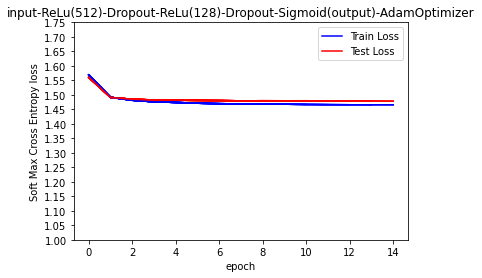

In [10]:
ydrop = MLP_RELU(x, weights_relu, biases)

# https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits
cost_drop = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = ydrop, labels = y_))
# https://github.com/amitmac/Question-Answering/issues/2
# there are many optimizers available: https://www.tensorflow.org/versions/r1.2/api_guides/python/train#Optimizers 
optimizer_drop_adam = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_drop)
optimizer_drop_sgdc = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost_drop)

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    fig,ax = plt.subplots(1,1)
    ax.set_xlabel('epoch') ; ax.set_ylabel('Soft Max Cross Entropy loss')
    xs, ytrs, ytes = [], [], []
    for epoch in range(training_epochs):
        train_avg_cost = 0.
        test_avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            
            # here we use AdamOptimizer
            _, c, w = sess.run([optimizer_drop_adam, cost_drop, weights_relu], feed_dict={x: batch_xs, y_: batch_ys})
            train_avg_cost += c / total_batch
            c = sess.run(cost_drop, feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            test_avg_cost += c / total_batch
        xs.append(epoch)
        ytrs.append(train_avg_cost)
        ytes.append(test_avg_cost)
        plt_dynamic(xs, ytrs, ytes, ax,np.arange(1, 1.8, step=0.05), "input-ReLu(512)-Dropout-ReLu(128)-Dropout-Sigmoid(output)-AdamOptimizer")

        if epoch%display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "train cost={:.9f}".format(train_avg_cost), "test cost={:.9f}".format(test_avg_cost))

    # plot final results
    plt_dynamic(xs, ytrs, ytes, ax,np.arange(1, 1.8, step=0.05), "input-ReLu(512)-Dropout-ReLu(128)-Dropout-Sigmoid(output)-AdamOptimizer")

    # we are calculating the final accuracy on the test data
    correct_prediction = tf.equal(tf.argmax(ydrop,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0 }))

Sanity check by finding the weight matrix deviation

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Text(0.5, 0, 'Output Layer ')

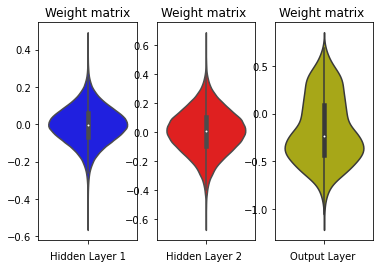

In [12]:
import seaborn as sns
h1_w = w['h1'].flatten().reshape(-1,1)
h2_w = w['h2'].flatten().reshape(-1,1)
out_w = w['out'].flatten().reshape(-1,1)


fig = plt.figure()
plt.subplot(1, 3, 1)
plt.title("Weight matrix")
ax = sns.violinplot(y=h1_w,color='b')
plt.xlabel('Hidden Layer 1')

plt.subplot(1, 3, 2)
plt.title("Weight matrix ")
ax = sns.violinplot(y=h2_w, color='r')
plt.xlabel('Hidden Layer 2 ')

plt.subplot(1, 3, 3)
plt.title("Weight matrix ")
ax = sns.violinplot(y=out_w,color='y')
plt.xlabel('Output Layer ')